# Regrid C384 tracer to C48 to show "representational error"

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cubedsphere as cs
import xesmf as xe

# get gamap's WhGrYlRd color scheme from file
from matplotlib.colors import ListedColormap
WhGrYlRd_scheme = np.genfromtxt('colormap/WhGrYlRd.txt',delimiter=' ')
WhGrYlRd = ListedColormap(WhGrYlRd_scheme/255.0)

In [2]:
!pip show xesmf

Name: xesmf
Version: 0.1.1
Summary: Universal Regridder for Geospatial Data
Home-page: https://github.com/JiaweiZhuang/xESMF
Author: Jiawei Zhuang
Author-email: jiaweizhuang@g.harvard.edu
License: MIT
Location: /n/home03/zhuangjw/miniconda3/envs/GCPy/lib/python3.6/site-packages
Requires: scipy, xarray, numpy, esmpy


In [3]:
#datadir = '~/FV3/output/processed/vertical_mean/' # Pleiades
datadir = "/n/home03/zhuangjw/FV3/outputdata/compressed/vertical_mean/" # Odyssey

ds1 = xr.open_dataset(datadir+'plume01_vmean_C48L160.nc', decode_times=False)
ds2 = xr.open_dataset(datadir+'plume01_vmean_C384L160.nc', decode_times=False)

In [4]:
def regrid(ds_in, ds_out, dr_in, filename=None, method='conservative'):
    """Convenience function for one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_out, method=method, 
                             filename=filename, reuse_weights=True)
    dr_out = regridder(dr_in)
    # keep weights for next time
    # regridder.clean_weight_file() 
    return dr_out

def C2C(ds_in, ds_out, dr_in):
    '''
    Regrid Cubedsphere to another Cubedsphere resolution
    '''
    dr_list = [None]*6
    for k in range(6):
        print(k+1, end=' ')
        dr_list[k] = regrid(ds_in.isel(tile=k), ds_out.isel(tile=k), 
                            dr_in.isel(tile=k), 
                            filename='weights_tile{0}.nc'.format(k+1))
    
    return xr.concat(dr_list, dim='tile')

In [5]:
dr_out = C2C(ds2, ds1, ds2['plume01'])

1 Reuse existing file: weights_tile1.nc
2 Reuse existing file: weights_tile2.nc
3 Reuse existing file: weights_tile3.nc
4 Reuse existing file: weights_tile4.nc
5 Reuse existing file: weights_tile5.nc
6 Reuse existing file: weights_tile6.nc


In [6]:
dr_out

<xarray.DataArray 'plume01' (tile: 6, y: 48, x: 48)>
array([[[2.999998e-06, 2.999993e-06, ..., 2.999999e-06, 2.999998e-06],
        [3.000000e-06, 3.000000e-06, ..., 3.000000e-06, 3.000000e-06],
        ...,
        [1.055575e-04, 2.992313e-05, ..., 3.000112e-06, 3.000077e-06],
        [8.330011e-05, 1.093251e-05, ..., 3.965792e-06, 4.562699e-06]],

       [[2.999998e-06, 2.999999e-06, ..., 2.999996e-06, 2.999999e-06],
        [3.000000e-06, 3.000000e-06, ..., 3.000000e-06, 3.000000e-06],
        ...,
        [3.406324e-06, 6.720314e-06, ..., 3.000000e-06, 3.000000e-06],
        [5.912964e-06, 4.101186e-06, ..., 2.999996e-06, 2.999999e-06]],

       ...,

       [[3.648118e-06, 3.000096e-06, ..., 3.000000e-06, 2.999998e-06],
        [4.257590e-06, 3.000097e-06, ..., 3.000000e-06, 3.000000e-06],
        ...,
        [1.090771e-05, 5.348224e-06, ..., 3.000000e-06, 2.999993e-06],
        [1.340361e-04, 7.400287e-05, ..., 3.000000e-06, 2.999998e-06]],

       [[2.999998e-06, 2.999998e-06, 

(-100, 120)

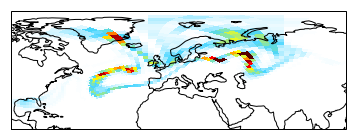

In [7]:
fig = plt.figure(figsize=[6, 4])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

cs.plotCS_quick(dr_out, ds1, ax, vmin=0, vmax=0.02, cmap=WhGrYlRd)
ax.set_ylim([10,88]);ax.set_xlim([-100,120])

1
2
3


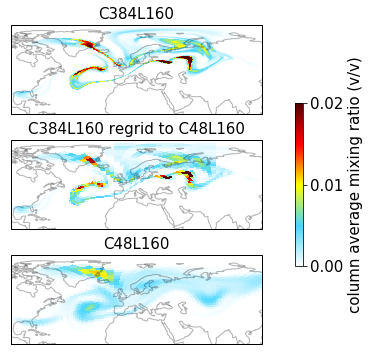

In [8]:
vmin,vmax = [0,0.02]

fig, axes = plt.subplots(3, 1 ,figsize=[6, 6],
                         subplot_kw=dict(projection=ccrs.PlateCarree()))

title_list = ['C384L160', 'C384L160 regrid to C48L160', 'C48L160']
dr_list = [ds2['plume01'], dr_out, ds1['plume01']]
ds_list = [ds2, ds1, ds1]

for i in range(3):
    print(i+1)
    dr = dr_list[i]
    ds = ds_list[i]
    ax = axes.ravel()[i]
    title = title_list[i]
    
    ax.coastlines(alpha=0.3)

    im = cs.plotCS( dr, ds, ax,
                   vmin=vmin, vmax=vmax, cmap=WhGrYlRd)

    ax.set_ylim([10,88]);ax.set_xlim([-100,120])
    ax.set_title(title, fontsize=15)     

# provide a list of axes to let the colorbar span all those axes
cb = fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.1, orientation='vertical',
             shrink=0.5,ticks=np.linspace(vmin,vmax,3))
             
cb.set_label("column average mixing ratio (v/v)", fontsize=15)
cb.ax.tick_params(labelsize=15)
    
#fig.tight_layout()

fig.savefig('C384_degrade_to_C48.png',dpi=400)